### <center> Assignment 3 Harris Corner Detector & Optical Flow </center>
<center> Computer Vision 1 University of Amsterdam </center>
    <center> Due 23:59, October 1, 2022 (Amsterdam time) </center>

## General Guidelines
Your code and discussion must be completed in this **jupyter notebook** before the deadline by submitting it to the Canvas Lab 3 Assignment. Submit your assignment in a **zip file**, with all the relevant files and images need to run your notebook. Name your zip file as follows:  **StudentID1_StudentID2_StudentID3.zip**
For full credit, make sure your answers follow these guidelines:

- Make sure you use the provided python environment. You can create the environment using conda and the provided YAML file using the following command: `conda env create --file=CV1_env.yaml`, then activate it as `conda activate cv1`. Using different packages versions may result in the impossibility to run the submitted code and therefore in the subtraction of points. Below you will find a code cell to check the versions of your packages. 
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions (in **<font color=green >Question** parts). Briefly describe what you implemented. **<font color=blue >Hint** parts are there to give you hints to answer questions.
- Try to understand the problem as much as you can. When answering a question, give evidence (qualitative and/or quantitative results, references to papers, etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make your notebook self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.
- Make sure all the code in your notebook runs without errors or bugs before submitting. Code that does not run can result in a lower grade. 

**Late submissions** are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.

**Plagiarism note:** Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

In [1]:
# python packages needed for this assignment
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.signal import convolve2d as conv
from scipy.ndimage import maximum_filter, gaussian_filter, rotate
import os
import matplotlib

In [2]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "3.4.2", "You're not using the provided Python environment!"
assert np.__version__ == "1.19.5", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.3.4", "You're not using the provided Python environment!"
assert scipy.__version__ == "1.7.3", "You're not using the provided Python environment!"
# Proceed to the next cell if you don't get any error.

## 1. Harris Corner Detector (45pts)
In this section, a derivation of the *[Harris Corner Detector](https://www.semanticscholar.org/paper/A-Combined-Corner-and-Edge-Detector-Harris-Stephens/6818668fb895d95861a2eb9673ddc3a41e27b3b3)* is presented.

Given a shift $(\Delta x,\Delta y)$ at a point $(x, y)$, the auto-correlation function is defined as:

$$c(\Delta x,\Delta y) = \sum\limits_{(x,y)\in W(x,y)} {w(x,y)(I(x+\Delta x,y+\Delta y)-I(x,y))^2} \tag {1}$$

where $W(x,y)$ is a window centered at point $(x,y)$ and $w(x,y)$ is a Gaussian function. For simplicity, from now on, $\sum\limits_{(x,y)\in W(x,y)}$ will be referred to as $\sum\limits_{W}$.
Approximating the shifted function by the first-order Taylor expansion we get:

\begin{eqnarray}
I(x+\Delta x,y+ \Delta y) & \approx & I(x,y) + I_x(x,y)\Delta x + I_y(x,y)\Delta y \tag {2} \\
&=& I(x,y) + [I_x(x,y) \ I_y(x,y)] \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}, \tag {3}
\end{eqnarray}

where $I_x$ and $I_y$ are partial derivatives of $I(x,y)$. The first gradients can be approximated by: 
\begin{eqnarray}
    I_x &=& \frac{\partial I}{\partial x} \approx I * G_x, \quad G_x = (-1,0,1) \tag {4} \\ 
    I_y &=& \frac{\partial I}{\partial y} \approx I * G_y, \quad G_y = (-1,0,1)^T \tag {5}
\end{eqnarray}


Note that using the kernel $(-1, 1)$ to approximate the gradients is also correct. The auto-correlation function can now be written as:
\begin{eqnarray}
c(\Delta x,\Delta y) &=& \sum\limits_{W} {w(x,y) (I(x+\Delta x,y+\Delta y)-I(x,y))^2} \tag {6} \\
& \approx & \sum\limits_{W} {w(x,y) ([I_x(x,y) \ I_y(x,y)]\begin{bmatrix} \Delta x \\ 
\Delta y \end{bmatrix})^2} \tag {7} \\
&=& [\Delta x \ \Delta y]Q(x,y)\begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}, \, \tag {8}
\end{eqnarray}

where $Q(x,y)$ is given by:

\begin{eqnarray}
Q(x,y) &=& \sum\limits_{W} w(x,y){\begin{bmatrix} I_x(x,y)^2  & I_x(x,y)I_y(x,y)  \\  I_x(x,y)I_y(x,y)  & I_y(x,y)^2   \end{bmatrix}} \tag {9} \\
&=& \begin{bmatrix} 
\sum\limits_{W}{I_x(x,y)^2} * w(x, y) & \sum\limits_{W}{I_x(x,y)I_y(x,y)} * w(x, y) \\  
\sum\limits_{W}{I_x(x,y)I_y(x,y)} * w(x, y) & \sum\limits_{W}{I_y(x,y)^2} * w(x, y)  \end{bmatrix} \tag {10}\\
&=& \begin{bmatrix} A & B \\  B & C  \end{bmatrix}.\, \tag {11}
\end{eqnarray}

The *cornerness* $H(x,y)$ is defined by the two eigenvalues of $Q(x,y)$, e.g. $\lambda_1$ and $\lambda_2$:

\begin{eqnarray}
\label{eq12}
H &=& \lambda_1 \lambda_2 - 0.04(\lambda_1 + \lambda_2)^2 \tag{12}\\
&=& det(Q) - 0.04(trace(Q))^2 \tag{13}\\
&=& (AC - B^2) - 0.04(A+C)^2. \ \tag{14}
\end{eqnarray}

In this section, you are going to implement $Equation ~\eqref{eq12}$ to calculate $H$ and use it to detect the corners in an image.

**<font color=blue > Hint**: For that purpose, you need to compute the elements of **Q**, i.e. $A$, $B$ and $C$. To do that, you need to calculate $I_x$, which is the smoothed derivative of the image. That can be obtained by convolving the first order Gaussian derivative, $G_d$, with the image $I$ along the x-direction. Then, **A** can be obtained by squaring $I_x$, and then convolving it with a Gaussian, $G$. Similarly, **B** and **C** can be obtained. For example, to get **C**, you need to convolve the image with $G_d$ along the y-direction (to obtain $I_y$), raise it to the square, then convolve it with $G$. 

**<font color=blue > Hint**: The corner points are the local maxima of **H**. Therefore, you should check for every point in $H$, (1) if it is greater than all its neighbours (in an $n \times n$ window centered around this point) and (2) if it is greater than the user-defined threshold. If both conditions are met, then the point is labeled as a corner point.

**<font color=green > Question - 1 (35-*pts*)**
    
1. Create a function to implement the Harris Corner Detector. Your function should return matrix $H$, the indices of rows of the detected corner points **r**, and the indices of columns of those points **c**, where the first corner is given by $(r[0],c[0])$.

    
2. Implement another function that plots three figures: The computed image derivatives $I_x$ and $I_y$, and the original image with the corner points plotted on it. Show your results on example images **toy/00000001.jpg** and **basketball/085.jpg**. Remember to experiment with different threshold values to see the impact on which corners are found.
    
    
3. Is the algorithm rotation-invariant? How about your implementation? Rotate **toy/00000001.jpg** image 45 and 90 degrees and run the Harris Corner Detector algorithm on the rotated images. Explain your answer and support it with your observations.

*Note:* You are allowed to use *scipy.signal.convolve2d* to perform convolution, and *scipy.ndimage.gaussian\_filter* to obtain your image derivatives. 
Include a demo function to run your code.

In [67]:
# Q1.1


def get_I_x(I):  # Partial derivative of intensity I by x
    G_x = np.array([-1, 0, 1]).reshape((1,3))
    I_x = conv(I, G_x, mode='same')
    return I_x


def get_I_y(I):  # Partial derivative of intensity I by y
    G_y = np.array([-1, 0, 1]).reshape((1,3)).T
    I_y = conv(I, G_y, mode='same')
    return I_y
          

def get_H(I, W_size, sigma):  # Cornerness function
    
    I_x = get_I_x(I)
    I_y = get_I_y(I)
    
    A = gaussian_filter(I_x**2, sigma)
    B = gaussian_filter(I_x * I_y, sigma)
    C = gaussian_filter(I_y**2, sigma)

    H = (A*C - B**2) - 0.04*(A + C)**2
    H = (H - np.min(H)) / np.max(H - np.min(H))  # Normalize H so that the threshold selection can be between 0 and 1
    
    return H


def HCD(I, W_size, sigma, thresh):  # Harris Corner Detector algorithm
    
    assert W_size % 2 != 0  # Assert that window size is odd because the window must have a center

    corners = [] # Corner coordinates
    
    # Create cornerness matrix
    H = get_H(I, W_size, sigma)
    
    # Find the corners
    for x in range(H.shape[0]):
        for y in range(H.shape[1]):
            
            W_offset = int((W_size - 1) / 2)  # Offset from the center (x,y) to get the neighborhood using the given window size
            
            # Get neighborhood limits around center (x,y)
            x_min = x - W_offset if x - W_offset >= 0 else 0
            x_max = x + W_offset if x + W_offset <= H.shape[0] else H.shape[0]
            y_min = y - W_offset if y - W_offset >= 0 else 0
            y_max = y + W_offset if y + W_offset <= H.shape[1] else H.shape[1]
            
            N = H[x_min:x_max, y_min:y_max]  # Neighborhood around the center (x,y)
            
            if H[x,y] == np.max(N) and H[x,y] > thresh:  # If the point satisfies the corner conditions
                corners.append([x,y])
    
    corners = np.array(corners)
    return corners


In [68]:
# Q1.2

def plot_HCD(I, I_x, I_y, corners):
    
    fig1, axs = plt.subplots(1, 2, figsize=(10,10))
    
    axs[0].set_title('Partial derivative Ix of I')
    axs[0].axis('off')
    axs[0].imshow(I_x, cmap='gray')
    
    axs[1].set_title('Partial derivative Iy of I')
    axs[1].axis('off')
    axs[1].imshow(I_y, cmap='gray')
    
    fig2 = plt.figure()
    plt.title('Corners of image using HCD')
    if corners.shape[0] != 0:  # If there are any corners
        plt.scatter(corners[:,1], corners[:,0], c='red', s=10)
    plt.imshow(I)

    
def run_HCD(img_dir, W_size, sigma, thresh, deg=0):
    
    print('Reading data...')
    I = plt.imread(img_dir)
    I = rotate(I, deg) if deg != 0 else I  # Rotate image if needed
    I_gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)  # Read image as grayscale

    print('Getting partial derivatives...')
    I_x = get_I_x(I_gray)
    I_y = get_I_y(I_gray)

    print('Calculating corners...')
    corners = HCD(I_gray, W_size, sigma, thresh)

    print(f'Number of corners found: {corners.shape[0]}')

    print('Plotting...\n')
    plot_HCD(I, I_x, I_y, corners)
    

Reading data...
Getting partial derivatives...
Calculating corners...
Number of corners found: 187
Plotting...

Reading data...
Getting partial derivatives...
Calculating corners...
Number of corners found: 177
Plotting...



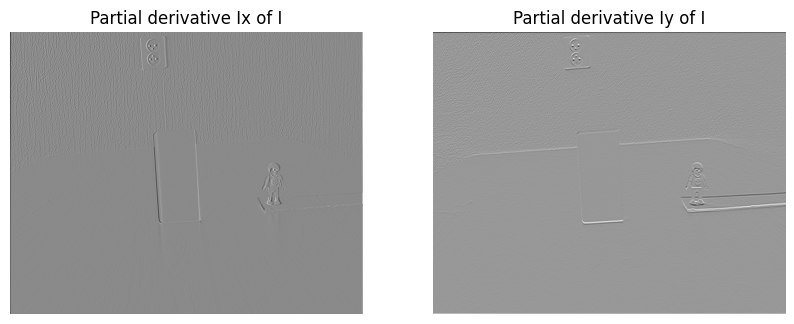

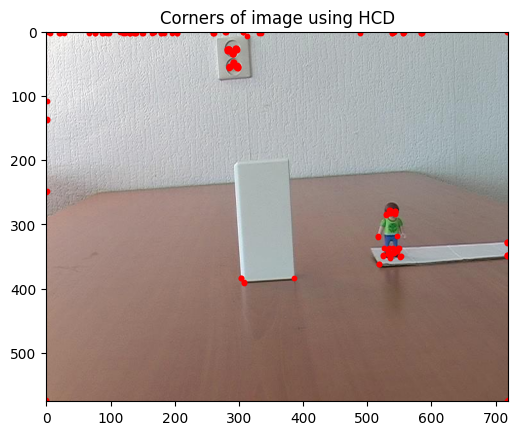

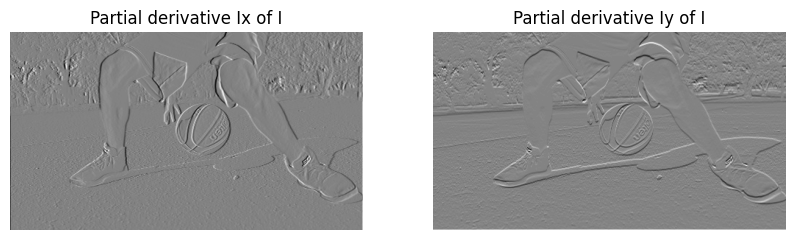

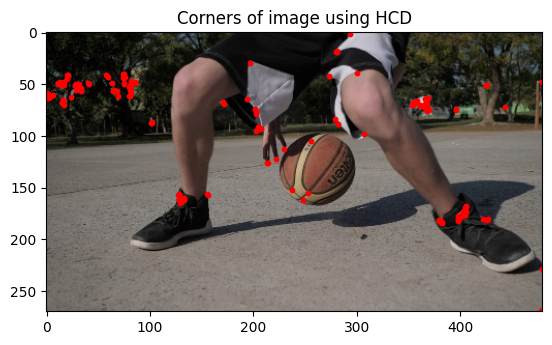

In [69]:
# Q1.2 (continue)

# Toy
run_HCD(img_dir='./data/toy/00000001.jpg', W_size=3, sigma=0.7, thresh=0.15)

# Basketball
run_HCD(img_dir='./data/basketball/085.jpg', W_size=3, sigma=0.5, thresh=0.5)

*Q1.3*

The HCD algorithm uses the scores of the cornerness matrix H to find the points that are most likely corners. This matrix is calculated by the eigenvalues of matrix Q which are invariant to rotation (eigenvectors rotate with image but eigenvalues stay the same). Therefore, theoretically H should be rotation invariant. In practice, looking at our implementation and results below, we can see that the algorithm is invariant to the rotation of 90 degrees but that is not the case for the 45 degree rotation as we needed to tweak the threshold to get similar, but not the same, results. This can be attributed to the interpolation required in the case of 45 degrees. In other words, when rotating 90 degrees the values of the pixels are preserved as they are. However, when rotating 45 degrees, because the positions of points in the image are translated to positions in-between pixels, the values of the pixels are interpolated. Therefore, even though it appears as the same image to the human eye, the color values are not the same and this possiby causes a change in the eigenvalues. Also, when rotating 45 degrees a black color is added to the empty pixels. Thus, this extra redundant information may affect the eigenvalues. Lastly, the final reason why the cornerness scores are the same with 90 degrees but not with 45 is because, in the case of 90 degrees, the partial derivatives Ix and Iy are the same as the original Iy and Ix respectively. In the case of 45 degrees, they are different and as a result Q and H are different too.

Reading data...
Getting partial derivatives...
Calculating corners...
Number of corners found: 219
Plotting...

Reading data...
Getting partial derivatives...
Calculating corners...
Number of corners found: 193
Plotting...



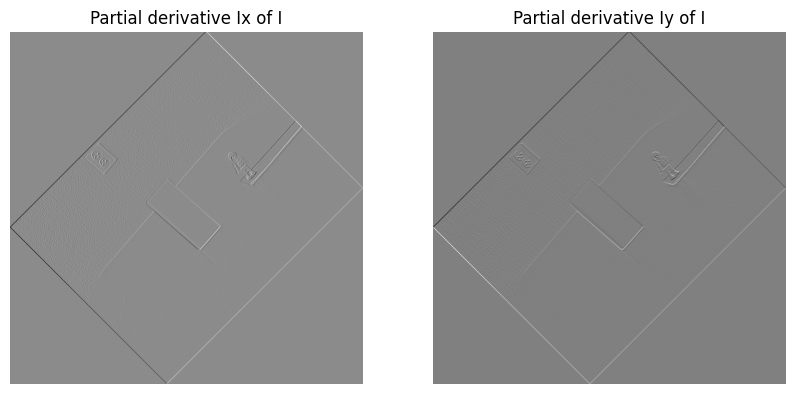

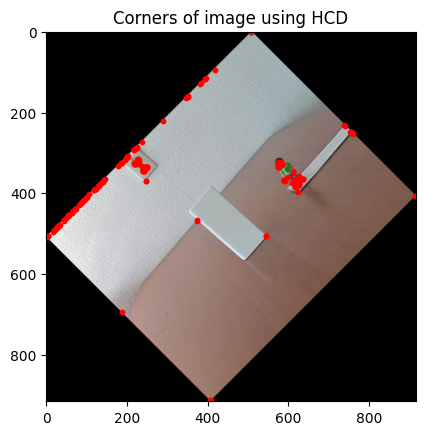

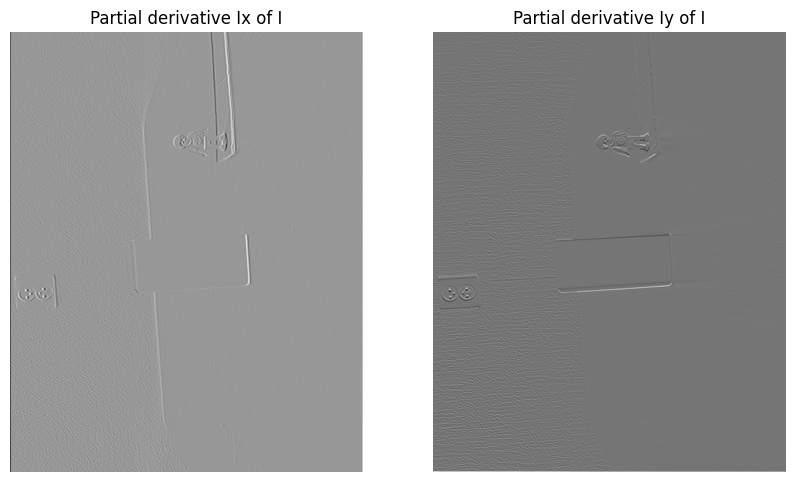

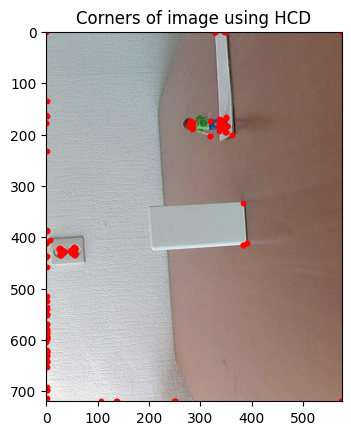

In [70]:
# Q1.3

# Toy rotated by 45 degrees
run_HCD(img_dir='./data/toy/00000001.jpg', W_size=3, sigma=0.7, thresh=0.21, deg=45)

# Toy rotated by 90 degrees
run_HCD(img_dir='./data/toy/00000001.jpg', W_size=3, sigma=0.7, thresh=0.15, deg=90)

**<font color=green > Question - 2 (10-*pts*)**
    
Now you have seen the cornerness definition of Harris on $Equation ~(12)$. Another relevant definition of cornerness is defined by  *[Shi and Tomasi](https://ieeexplore.ieee.org/document/323794)*, after the original definition of Harris. Check their algorithm and answer the following questions:
    
1. How do they define cornerness? Write down their definition using the notations of $Equation ~(12)$.
    

2. Does the Shi-Tomasi Corner Detector satisfy the following properties: translation invariance, rotation invariance, scale invariance? Explain your reasoning.
    

3. In the following scenarios, what could be the relative cornerness values assigned by Shi and Tomasi? Explain your reasoning.
    
    (a) Both eigenvalues are near 0.
    
    (b) One eigenvalue is big and the other is near zero.
    
    (c) Both eigenvalues are big.

*Q2*

<br> 

1.
According to J. Shi and C. Tomasi, detecting corners as features for motion tracking is not optimal as this method makes an assumption about the best window without taking into account what works best for the tracking algorithm. In their paper they use feature windows with a good score of texturedness (that is, it can be tracked well) which are selected by optimizing the tracker's accuracy to them. To select the windows, the eigenvalues of Z are calculated, and if both eigenvalues have big values, big enough to be over the user-defined threshold, then the window is selected as a feature. Two big eigenvalues represent patterns with a lot of texture information such as corners, salt-and-pepper textures and other patterns that can be tracked reliably.

The equivalent "cornerness" score, or more accurately the "texturedness", is calculated as follows:

\begin{eqnarray}
H(x,y) &=& min(\lambda_1, \lambda_2)\\
\end{eqnarray}

where λ1, λ2 are the eigenvalues of matrix Z for the window around center point (x,y):

\begin{eqnarray}
Z &=&
\begin{bmatrix}
g_x^{2} & g_{x}g_{y}\\
g_{x}g_{y}\ & g_y^{2}\\
\end{bmatrix}
\end{eqnarray}

The final selected feature windows are those where H(x,y) > λ.

<br> 

2.
- It is invariant to translation because the eigenvalues (that is, the cornerness) are extracted from matrix Z which contains the products of the partial derivatives and, as we know, derivation is invariant to shifting [1].
- It is invariant to rotation as the cornerness matrix depends solely on the eigenvalues which, as we mentioned in Q1.3, are rotation invariant. 
- It is not invariant to scaling because, just like in HCD [1], when scaling the image without changing the window size, windows that contained corners will now appear as if they contain edges. Thus, the algorithm will not detect them as points of interest because the eigenvalues of the windows will be different, and thus the cornerness too.

[1] https://www.cs.cornell.edu/courses/cs4670/2018sp/lec13-feature-sim.pdf.


<br> 

3.

a. If both eigenvalues are near 0, the cornerness is 0 according to the above formula. That is, the intensity inside the window is almost constant [J. Shi, C. Tomasi] and, therefore, it doesn't contain any texture information as it is most likely a solid color and definitely not a corner, hence why the cornerness / texturedness is zero.
    
b. If only one of the eigenvalues is big and the other is close to 0, that means the pattern inside the window is unidirectional [J. Shi, C. Tomasi]. In other words, the texture contains lines or edges. Therefore, the cornerness according to the formula will be close to zero.

c. If both eigenvalues have big values, then the cornerness will be equal to the smallest one of the two according to the formula. That is expected as in this case the window contains patterns with a lot of texture information such as corners [J. Shi, C. Tomasi].




## 2. Optical Flow - Lucas-Kanade Algorithm (35pts)

Optical flow is the apparent motion of image pixels or regions from one frame to the next, which results from moving objects in the image or from camera motion. Underlying optical flow is typically an assumption of $\textit{brightness constancy}$. That is the image values (brightness, color, etc) remain constant over time, though their 2D position in the image may change. Algorithms for estimating optical flow exploit this assumption in various ways to compute a velocity field that describes the horizontal and vertical motion of every pixel in the image. For a 2D+t dimensional case a voxel at location $(x, y, t)$ with intensity $I(x, y, t)$ will have moved by $\delta_x$, $\delta_y$ and $\delta_t$ between the two image frames, and the following image constraint equation can be given:

\begin{equation}
I(x,y,t) = I(x+\delta_x, y+\delta_y, t+\delta_t). \tag{15}
\end{equation}

Assuming the movement to be small, the image constraint at I(x, y, t) can be extended using Taylor series, truncated to first-order terms:

\begin{equation}
\tag{16}
I(x+\delta_x, y+\delta_y, t+\delta_t) = I(x,y,t)+\frac{\partial I}{\partial x}\delta_x +\frac{\partial I}{\partial y}\delta_y+\frac{\partial I}{\partial t}\delta_t
\end{equation}

Since we assume changes in the image can purely be attributed to movement, we will get:

\begin{equation}
\tag{17}
\frac{\partial I}{\partial x}\frac{\delta_x}{\delta_t} +   \frac{\partial I}{\partial y}\frac{\delta_y}{\delta_t} + \frac{\partial I}{\partial t}\frac{\delta_t}{\delta_t} = 0
\end{equation}

or

\begin{equation}
\tag{18}
I_x V_x + I_y V_y = -I_t,
\end{equation}

where $V_x$ and $V_y$ are the $x$ and $y$ components of the velocity or optical flow of $I(x,y,t)$. Further, $I_x$, $I_y$ and $I_t$ are the derivatives of the image at $(x, y, t)$ in the corresponding directions, which defines the main equation of optical flow.

Optical flow is difficult to compute for two main reasons. First, in image regions that are roughly homogeneous, the optical flow is ambiguous, because the brightness constancy assumption is satisfied by many different motions. Second, in real scenes, the assumption is violated at motion boundaries and by miscellaneous lighting, non-rigid motions, shadows, transparency, reflections, etc. To address the former, all optical flow methods make some sort of assumption about the spatial variation of the optical flow that is used to resolve the ambiguity. Those are just assumptions about the world which are approximate and consequently may lead to errors in the flow estimates. The latter problem can be addressed by making much richer but more complicated assumptions about the changing image brightness or, more commonly, using robust statistical methods which can deal with 'violations' of the brightness constancy assumption.

### Lucas-Kanade Algorithm

We will be implementing the [Lucas-Kanade method](https://www.ri.cmu.edu/pub_files/pub3/lucas_bruce_d_1981_2/lucas_bruce_d_1981_2.pdf) for Optical Flow estimation. This method assumes that the optical flow is essentially constant in a local neighborhood of the pixel under consideration. Therefore, the main equation of the optical flow can be assumed to hold for all pixels within a window centered at the pixel under consideration. Let's consider pixel $p$. Then, for all pixels around $p$, the local image flow vector $(V_x, V_y)$ must satisfy:

\begin{array}{c}
\tag{19}
  I_x(q_1)V_x + I_y(q_1)V_y = - I_t(q_1)\\
  I_x(q_2)V_x + I_y(q_2)V_y = - I_t(q_2)\\
  \vdots \\
  I_x(q_n)V_x + I_y(q_n)V_y = - I_t(q_n),\\
\end{array}

where $q_1$, $q_2$, ... $q_n$ are the pixels inside the window around $p$. $I_x(q_i)$, $I_y(q_i)$, $I_t(q_i)$ are the partial derivatives of the image $I$ with respect to position $x$, $y$ and time $t$, evaluated at the point $q_i$ and at the current time. 

These equations can be written in matrix to form $Av=b$, where

\begin{equation}
\tag{20}
A = \begin{bmatrix}
I_x(q_1) & I_y(q_1)\\
I_x(q_2) & I_y(q_2)\\
\vdots   & \vdots  \\
I_x(q_n) & I_y(q_n)
\end{bmatrix},
v = \begin{bmatrix}
V_x\\ V_y
\end{bmatrix}, \mbox{ and }
b = \begin{bmatrix}
-I_t(q_1)\\
-I_t(q_2)\\
\vdots   \\
-I_t(q_n)
\end{bmatrix}.
\end{equation}

This system has more equations than unknowns and thus it is usually over-determined. The Lucas-Kanade method obtains a compromise solution by the weighted-least-squares principle. Namely, it solves the $2\times 2$ system as

\begin{equation}
\tag{21}
A^T A v = A^T b
\end{equation}

or

\begin{equation}
v = (A^T A)^{-1} A^T b.
\label{eqA} \tag{22}
\end{equation}

**<font color=green > Question - 1 (30-*pts*)**
    
For this assignment, you will be given three pairs of images: **sphere1.ppm**, **sphere2.ppm**; **synth1.pgm**, **synth2.pgm**; and **monkaa1.png**, **monkaa2.png**. You should estimate the optical flow between these two pairs. That is, you will get optical flow for sphere images, and for synth images separately. Implement the Lucas-Kanade algorithm using the following steps.

    
1. Divide  input  images  on  non-overlapping  regions,  each  region  being  $15\times 15$.
    
    
2. For each region compute $A$, $A^T$ and $b$. Then, estimate optical flow as given in $Equation~\eqref{eqA}$.
    
    
3. When you have estimation for optical flow $(V_x, V_y)$ of each region, you should display the results. There is a **matplotlib** function <font color=green >quiver</font> which plots a set of two-dimensional vectors as arrows on the screen. Try to figure out how to use this to show your optical flow results.

<em>Note</em>: You are allowed to use $\texttt{scipy.signal.convolve2d}$ to perform convolution.
Include a demo function to run your code.

**<font color=blue > Hint**: You can use regions that are $15\times 15$ pixels that are non-overlapping. That is, if input images are $256\times 256$, you should have an array of $17\times 17$ optical flow vectors at the end of your procedure. As we consider $15\times 15$ regions, your matrix $\textbf{A}$ will have the following size $225\times 2$, and the vector $\mathbf{b}$ will be $225\times 1$.

**<font color=blue > Hint**: Carefully read the documentation of $\textbf{matplotlib}'s$ function <font color="green">$\texttt{quiver}$</font>. By default, the angles of the arrows are 45 degrees counter-clockwise from the horizontal axis. This means your arrows might point in the wrong direction! Also, play around with the arrow scaling.

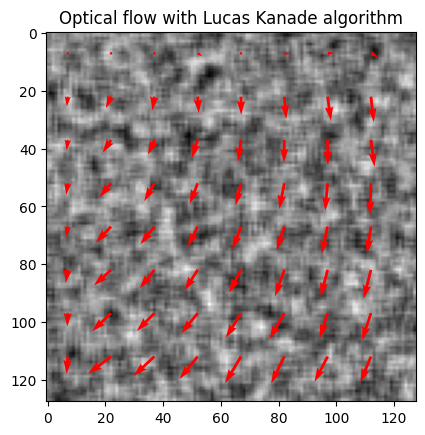

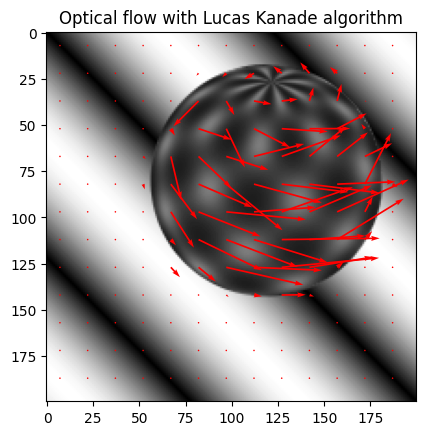

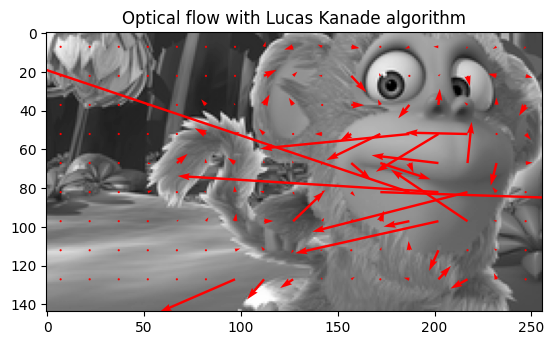

In [73]:
sphere1 = cv2.imread('data/sphere1.ppm')
sphere2 = cv2.imread('data/sphere2.ppm')

synth1 = cv2.imread('data/synth1.pgm')
synth2 = cv2.imread('data/synth2.pgm')

monkaa1 = cv2.imread('data/monkaa1.png')
monkaa2 = cv2.imread('data/monkaa2.png')

def Image_Regions(Img):
    # Discard the would-be remaining pixels after dividing in 15x15 blocks.
    Img_width = Img.shape[0] - (Img.shape[0] % 15)
    Img_length = Img.shape[1] - (Img.shape[1] % 15)
    regions = []
    arrow_locs = []
    
    # Divide input images on non-overlapping regions, each region being  15×15.
    for j in range(0, Img_length, 15):
        for i in range(0, Img_width, 15):
            regions.append(Img[i:i+15, j:j+15])
            # save center of region for plotting
            arrow_locs.append([i+7, j+7])
    return regions, arrow_locs

def Optical_Flow(Rx, Ry, Rt):
    A = np.vstack((Rx.flatten(), Ry.flatten())).T
    # to prevent a singular matrix some trivial noise is added to A
    A[0,0] += 0.0001
    b = Rt.flatten()
    v = np.linalg.inv(A.T @ A) @ A.T @ -b
    return v
            
    
def Plot_Lucas_Kanade(Img1, xlocs, ylocs, Vx, Vy):
    plt.title('Optical flow with Lucas Kanade algorithm')
    plt.quiver(ylocs, xlocs, Vx, Vy, color = 'red', angles = 'xy', scale_units='xy')
    plt.imshow(Img1, cmap = 'gray')
    plt.show()

def Lucas_Kanade(Img1, Img2):
    Img1 = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY).astype(np.float32)
    Img2 = cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY).astype(np.float32)
    
    Ix = conv(Img1, np.array([[-1,0,1]]), mode='same') 
    Iy = conv(Img1, np.array([[-1,0,1]]).T, mode='same')
    It = Img1 - Img2
    
    Rx, arrow_locs = Image_Regions(Ix)
    Ry  = Image_Regions(Iy)[0]
    Rt = Image_Regions(It)[0]
    
    xlocs = np.array(arrow_locs)[:, 0]
    ylocs = np.array(arrow_locs)[:, 1]

    V = []
    for i in range(len(Rx)):
        V.append(Optical_Flow(Rx[i], Ry[i], Rt[i]))
    Vx = np.array(V)[:, 0]
    Vy = np.array(V)[:, 1]
    
    Plot_Lucas_Kanade(Img1, xlocs, ylocs, Vx, Vy)
    return xlocs, ylocs, Vx, Vy

xlocs, ylocs, Vx, Vy = Lucas_Kanade(synth1, synth2)
xlocs, ylocs, Vx, Vy = Lucas_Kanade(sphere1, sphere2)
xlocs, ylocs, Vx, Vy = Lucas_Kanade(monkaa1, monkaa2)

**<font color=green > Question - 2 (5-*pts*)**

Now you have seen one of the optical flow estimation methods developed by Lucas and Kanade. There are several more methods in the literature. The *[Horn-Schunck method](https://www.sciencedirect.com/science/article/abs/pii/0004370281900242)* is one of them. Check their method, compare it to Lucas-Kanade and answer the following questions:
1. At what scale do the algorithms operate; i.e local or global? Explain your answer.


2. How do the algorithms behave at flat regions?

1. The Lucas-Kanade algorithm operates locally as it needs only a small subset of an image to determine optic flow, while the Horn-Schunck algorithm operates globally as it uses the entire image to determine optic flow.
2. Because the Lucas-Kanade works locally, it will fail to capture movement on flat regions due to the aperture problem. The Horn-Schunck algorithm assumes the flow of an image varies smoothly almost everywhere in the image. Under this constraint, the algorithm is succeptible to distortions but is able to capture movement on flat regions. 

## 3. Feature Tracking (20-pts)

In this part of the assignment, you will implement a simple feature-tracking algorithm. The aim is to extract visual features, like corners, and track them over multiple frames.

**<font color=green > Question - 1 (18-*pts*)**

1. Implement a simple feature-tracking algorithm by following below steps.
    
    (a) Locate feature points on the first frame by using the Harris Corner Detector, that you implemented in Section 1. 
    
    (b) Track these points using the Lucas-Kanade algorithm for optical flow estimation, that you implemented in the Section 2.
    
    
2. Prepare a video for each sample image sequences. These videos should visualize the initial feature points and the optical flow. Test your implementation and prepare visualization videos for **basketball** and **toy** samples.

Include a demo function to run your code.

In [ ]:
# Q1 - Type your code here
f_basketball = './data/basketball/'
f_toy = './data/toy/'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def make_video(folder, output_file, fourcc_str='mp4v', ):
    ims = load_images_from_folder(folder)
    h, w, layers = ims[0].shape
    size = (w, h)
    fourcc = cv2.VideoWriter_fourcc(*fourcc_str)
    output_vid = cv2.VideoWriter(output_file, fourcc, 15, size)
    
    for im in ims:
        output_vid.write(im)
    
make_video(f_basketball, 'basketball.mp4')
make_video(f_toy, 'toy.mp4')

def play_video(video):
    cap = cv2.VideoCapture(video)
   
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            cv2.imshow("frame", frame)
            if cv2.waitKey(int(1000/15)) == ord('q'):
                break
    
    cap.release()
    cv2.destroyAllWindows()

play_video('toy.mp4')

*Q1 - Type your answers here*

**<font color=green > Question - 2 (2-*pts*)**

Why do we need feature tracking even though we can detect features for each and every frame? 

*Q2 - Type your answers here*